In [1]:
import xarray as xr
import numpy as np
import glob
import os
import matplotlib.pyplot as plt

from AR_model import AR_model
from AR_model_loader import AR_model_loader
from utils import dataset_to_numpy_grid

read_path  =  '/home/hanna/lagrings/ERA5_monthly/'
write_path = '/home/hanna/lagrings/results/ar/'

# Developing code DataLoaders 
1. Start by finding the files corresponding to the dates start and stop
2. Read files to xarray, crop data to start date 
3. force it to be a even number so you get as many samples as you need

* start, stop - type datetime strings
* start, stop - 
* if only start is give - you get that month???

In [2]:
def get_list_of_files(start = '2012-01-01', stop = '2012-01-31'):
    """ Returns list of files containing data for the requested period.
    """
    # Remove date.
    parts = start.split('-')
    start_search_str = '{}_{:02d}'.format(parts[0], int(parts[1]))
     
    parts = stop.split('-')
    stop_search_str = '{}_{:02d}'.format(parts[0], int(parts[1]))
    
    if start_search_str == stop_search_str:
        subset = glob.glob(os.path.join( read_path, '{}*.nc'.format(start_search_str)))
    else:               
        min_fil = os.path.join(read_path, start_search_str+ '_q.nc')
        max_fil = os.path.join(read_path, stop_search_str+ '_tcc.nc')

        # get all files
        files = glob.glob(os.path.join( read_path, '*.nc' ))
        files = np.sort(files) # sorting then for no particular reson

        smaller = files[files <= max_fil]  
        subset  = smaller[smaller >= min_fil] # results in all the files
    assert len(subset)%5==0, "Not five of each files, missing variables in file list!"
    return subset

In [3]:
def get_xarray_dataset_for_period(start = '2012-01-01', stop = '2012-01-31'):
    """ Gets data from the requested period into a xarray dataset. """
    from utils import merge 
    files = get_list_of_files(start = start, stop = stop)
    data = merge(files)
    data = data.sel(time = slice(start, stop))
    return data

In [4]:
def dataset_to_numpy_order(dataset, order):
    """
    dataset : xr.Dataset
        Contains the data you want to make a prediction based.

    TODO add explination column???

    keep the order of xarray time, lat, lon
    """
    times = dataset.time.values
    
    n_lat = len(dataset.latitude.values)
    n_lon = len(dataset.longitude.values)
    
    X = np.zeros( (len(times)-order, n_lat, n_lon, order+5) )
    y = np.zeros( (len(times)-order, n_lat, n_lon) )
    # X.shape = (lat, lon, variables, times)

    q   = dataset.q.values
    t2m = dataset.t2m.values
    r   = dataset.r.values
    sp  = dataset.sp.values
    tcc = dataset.tcc.values

    X[:, :, :, 0] = q[:-order,:,:]
    X[:, :, :, 1] = t2m[:-order,:,:]
    X[:, :, :, 2] = r[:-order,:,:]
    X[:, :, :, 3] = sp[:-order,:,:]
    X[:, :, :, 4] = 1 # bias

    y[:, :, :] = tcc[:-order]
    y = y[:, :, :, np.newaxis]
    
    index = 5

    # tcc1, tcc2, ..., tcc_n
    for temp_order in range(1, order+1):
        a = times[:-temp_order]
        b = times[temp_order:]
        bo = [element.astype(int) == temp_order for element in (b-a).astype('timedelta64[h]') ]

        remove_from_end = order - temp_order
        if remove_from_end != 0:
            #remove_from_end = 1
            # Which clouds to add at which column, remember that they shoudl start from t-1, t-2, t-3 ...
            X[:, :, :, index] = tcc[temp_order:, :, :][bo][:-remove_from_end, :, :]
        else:
            X[:, :, :, index] = tcc[temp_order:, :, :][bo]
        index+=1
    return R[:, :, :, :-1], R[:, :, : , -1] 

In [11]:
dataset = get_xarray_dataset_for_period()
order = 1
times = dataset.time.values

n_lat = len(dataset.latitude.values)
n_lon = len(dataset.longitude.values)

X = np.zeros( (len(times)-order, n_lat, n_lon, order+5) )
y = np.zeros( (len(times)-order, n_lat, n_lon) )
# X.shape = (lat, lon, variables, times)

q   = dataset.q.values
t2m = dataset.t2m.values
r   = dataset.r.values
sp  = dataset.sp.values
tcc = dataset.tcc.values

X[:, :, :, 0] = q[:-order,:,:]
X[:, :, :, 1] = t2m[:-order,:,:]
X[:, :, :, 2] = r[:-order,:,:]
X[:, :, :, 3] = sp[:-order,:,:]
X[:, :, :, 4] = 1 # bias

y[:, :, :] = tcc[:-order]
y = y[:, :, :, np.newaxis]

index = 5

# tcc1, tcc2, ..., tcc_n
for temp_order in range(1, order+1):
    a = times[:-temp_order]
    b = times[temp_order:]
    bo = [element.astype(int) == temp_order for element in (b-a).astype('timedelta64[h]') ]

    remove_from_end = order - temp_order
    if remove_from_end != 0:
        #remove_from_end = 1
        # Which clouds to add at which column, remember that they shoudl start from t-1, t-2, t-3 ...
        X[:, :, :, index] = tcc[temp_order:, :, :][bo][:-remove_from_end, :, :]
    else:
        X[:, :, :, index] = tcc[temp_order:, :, :][bo]
    index+=1


TypeError: int() takes at most 2 arguments (4 given)

In [18]:
num.shape
# TODO : Delete columns with nan's
n_times, n_lat, n_lon, n_vars = X.shape
C = np.concatenate([X, y], 3)
R = C[(~np.isnan(C))]

flatten = (n_vars+1)*n_lon*n_lat
num = R.reshape((int(len(R)/flatten), n_lat, n_lon, n_vars+1))


(743, 81, 161, 7)

In [10]:
67826241/num

743.0

In [9]:
num = 7*81*161

In [8]:
R.reshape(np.shape(C))

array([[[[6.60821097e-03, 2.89623779e+02, 6.77123718e+01, ...,
          1.00000000e+00, 1.00000000e+00, 2.75562696e-01],
         [6.72694342e-03, 2.89602295e+02, 6.92084656e+01, ...,
          1.00000000e+00, 1.00000000e+00, 8.04150883e-01],
         [6.83280127e-03, 2.89510498e+02, 7.05717468e+01, ...,
          1.00000000e+00, 1.00000000e+00, 7.75032922e-01],
         ...,
         [6.31543295e-03, 2.84697998e+02, 7.27592468e+01, ...,
          1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
         [6.19431632e-03, 2.84594482e+02, 7.25483093e+01, ...,
          1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
         [6.03266852e-03, 2.84459717e+02, 7.21029968e+01, ...,
          1.00000000e+00, 1.00000000e+00, 1.00000000e+00]],

        [[6.63252966e-03, 2.89623779e+02, 6.80053406e+01, ...,
          1.00000000e+00, 1.00000000e+00, 6.07090427e-01],
         [6.74029486e-03, 2.89610107e+02, 6.90912781e+01, ...,
          1.00000000e+00, 9.97358326e-01, 7.47137794e-01],
        

In [7]:
a = R[(~np.isnan(C))]
a

IndexError: too many indices for array

In [11]:
d = dataset_to_numpy_order(dataset = data, order = 1)

(743, 81, 161, 6) (743, 81, 161, 1)
(743, 81, 161, 7)
(743, 81, 161, 7)


MemoryError: Unable to allocate array with shape (67826241,) and data type float64

In [ ]:
X = d[0]
y = d[1]

In [ ]:
X.shape, y.shape

In [20]:
C.shape

(741, 81, 161, 9)

In [39]:
len(files)

895

In [41]:
sort = np.sort(files)

In [43]:
sort[:5]

array(['/home/hanna/lagrings/ERA5_monthly/2004_01_q.nc',
       '/home/hanna/lagrings/ERA5_monthly/2004_01_r.nc',
       '/home/hanna/lagrings/ERA5_monthly/2004_01_sp.nc',
       '/home/hanna/lagrings/ERA5_monthly/2004_01_t2m.nc',
       '/home/hanna/lagrings/ERA5_monthly/2004_02_q.nc'], dtype='<U52')

In [49]:
max_fil = '/home/hanna/lagrings/ERA5_monthly/2014_05_tcc.nc'
min_fil = '/home/hanna/lagrings/ERA5_monthly/2012_03_q.nc'
files = np.array(files)

In [53]:
len(subset)

132

In [55]:
np.sort(subset)

array(['/home/hanna/lagrings/ERA5_monthly/2012_03_r.nc',
       '/home/hanna/lagrings/ERA5_monthly/2012_03_sp.nc',
       '/home/hanna/lagrings/ERA5_monthly/2012_03_t2m.nc',
       '/home/hanna/lagrings/ERA5_monthly/2012_03_tcc.nc',
       '/home/hanna/lagrings/ERA5_monthly/2012_04_q.nc',
       '/home/hanna/lagrings/ERA5_monthly/2012_04_r.nc',
       '/home/hanna/lagrings/ERA5_monthly/2012_04_sp.nc',
       '/home/hanna/lagrings/ERA5_monthly/2012_04_t2m.nc',
       '/home/hanna/lagrings/ERA5_monthly/2012_04_tcc.nc',
       '/home/hanna/lagrings/ERA5_monthly/2012_05_q.nc',
       '/home/hanna/lagrings/ERA5_monthly/2012_05_r.nc',
       '/home/hanna/lagrings/ERA5_monthly/2012_05_sp.nc',
       '/home/hanna/lagrings/ERA5_monthly/2012_05_t2m.nc',
       '/home/hanna/lagrings/ERA5_monthly/2012_05_tcc.nc',
       '/home/hanna/lagrings/ERA5_monthly/2012_06_q.nc',
       '/home/hanna/lagrings/ERA5_monthly/2012_06_r.nc',
       '/home/hanna/lagrings/ERA5_monthly/2012_06_sp.nc',
       '/home/h

# Example of functionality available in AR_model and AR_model_loader

In [2]:
ar_model = AR_model() # create instance of AR model
model_loaded = AR_model_loader() # Create instance of AR model loader
W = model_loaded.load_model_to_numpy() # Load the test weights available in results folder
ar_model.set_weights_from_loaded_model(W) # Set the result weights in the AR model
X, y = dataset_to_numpy_grid(ar_model.dataset) # Load data for evaluation 
Y = ar_model.predict(X) # Make a prediction using the loaded weights on the training data.
ar_model.store_performance(Y, y) # store the performace (mse, ase, r2) in results under test performance 
result = ar_model.evaluate_ds # retrieve the results, use seaborn to plot the 

Text(0.5, 1.0, 'r2')

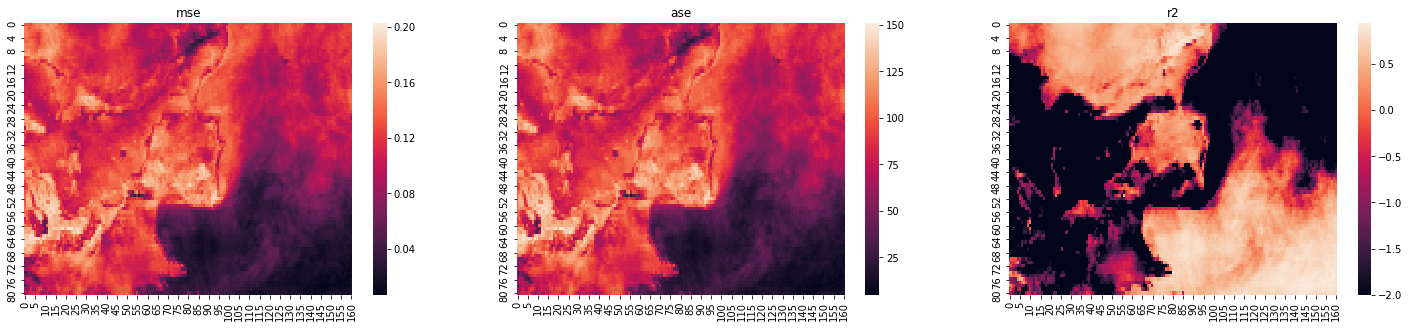

In [34]:
fig, axes = plt.subplots(1, 3, figsize = (25, 5))

sns.heatmap(result.mse.values[:,:], ax = axes[0]) 
axes[0].set_title('mse')

sns.heatmap(result.ase.values[:,:], ax = axes[1]) 
axes[1].set_title('ase')

sns.heatmap(result.r2.values[:,:], ax = axes[2], vmin = -2) 
axes[2].set_title('r2')

In [6]:
# Now you can make the predictor.

In [15]:
import seaborn as sns

# Make plotting routine suitable for this later 

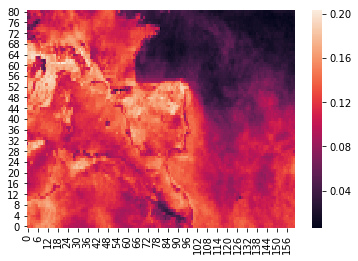

In [17]:
ax = sns.heatmap(result.mse.values[:,:], ax = axes[0]) # obs this is made based on the old regridded data, the files are not moved
ax.invert_yaxis()

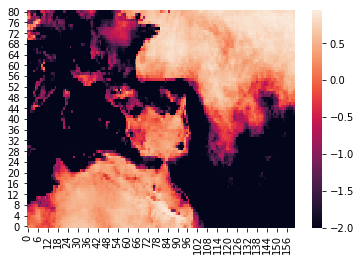

In [20]:
ax = sns.heatmap(result.r2.values[:,:], vmin = -2) # obs this is made based on the old regridded data, the files are not moved
ax.invert_yaxis()

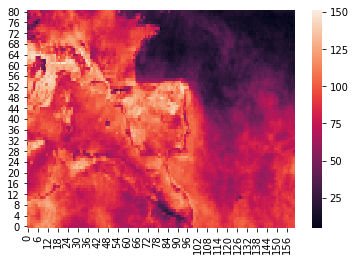

In [21]:
ax = sns.heatmap(result.ase.values[:,:]) # obs this is made based on the old regridded data, the files are not moved
ax.invert_yaxis()

In [11]:
# To save time load model and make prediction code based on this.

IndexError: invalid index to scalar variable.

In [12]:
# Make code that checks stored models that checs if this model is calibrated before it 

In [13]:
X.shape, y.shape

((744, 81, 161, 5), (744, 81, 161, 1))

In [14]:
# 1. Make predicction
# 2. Evaluate using mse and r2-

In [17]:
W.shape

(81, 161, 5)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 161 is different from 5)

In [15]:
test_date = '2012_01'
files = glob.glob(os.path.join(read_path, '*{}*.nc'.format(test_date)))

In [16]:
files # assert len(files) != 5

['/home/hanna/lagrings/ERA5_monthly/2012_01_q.nc',
 '/home/hanna/lagrings/ERA5_monthly/2012_01_r.nc',
 '/home/hanna/lagrings/ERA5_monthly/2012_01_t2m.nc',
 '/home/hanna/lagrings/ERA5_monthly/2012_01_sp.nc',
 '/home/hanna/lagrings/ERA5_monthly/2012_01_tcc.nc']

In [70]:
def dataset_to_numpy_order(dataset, order):
    """
    dataset : xr.Dataset
        Contains the data you want to make a prediction based.
    
    TODO add explination column???
        
    keep the order of xarray time, lat, lon
    """
    times = dataset.time.values
    X = np.zeros( (len(times)-order, n_lat, n_lon, order+5) )
    y = np.zeros( (len(times)-order, n_lat, n_lon) )
    # X.shape = (lat, lon, variables, times) 
    
    q   = dataset.q.values
    t2m = dataset.t2m.values
    r   = dataset.r.values
    sp  = dataset.sp.values
    tcc = dataset.tcc.values
    
    X[:, :, :, 0] = q[:-order,:,:]
    X[:, :, :, 1] = t2m[:-order,:,:]
    X[:, :, :, 2] = r[:-order,:,:]
    X[:, :, :, 3] = sp[:-order,:,:]
    X[:, :, :, 4] = 1 # bias
    
    y[:, :, :] = tcc[:-order]
    
    index = 5
    
    # tcc1, tcc2, ..., tcc_n
    for temp_order in range(1, order+1):
        a = times[:-temp_order]
        b = times[temp_order:]
        bo = [element.astype(int) == temp_order for element in (b-a).astype('timedelta64[h]') ]
        
        remove_from_end = order - temp_order
        if remove_from_end != 0:
            #remove_from_end = 1
            # Which clouds to add at which column, remember that they shoudl start from t-1, t-2, t-3 ...  
            X[:, :, :, index] = tcc[temp_order:, :, :][bo][:-remove_from_end, :, :]
        else:
            X[:, :, :, index] = tcc[temp_order:, :, :][bo]
        index+=1     
    # TODO : Delete columns with nan's
    return X, y

# Deal with missing values
## Merge datasets and only keep the times present in both 

# Store the results from the regression in nc-files

* 0: q
* 1: t2m
* 2: r
* 3: sp
* 4: bias

##  Make prediction and calculate R2 and MSE both training and test
### This file contains
* MSE_train
* MSE_test

* R2_train
* R2_test

## Compare results to normalized predictions.

In [ ]:
def prep_data_for_prediction(data, order):
    """ Preperation of data to make prediction
    
    data : xr.Dataset 
    
    order : int
        The n-th order of autoregressive model. Number of past cloud cover included.     
    """
    
    # Determine how many times have information about for cloud cover in 'order' previous steps.
    X = None
    
    return X

In [61]:
def keep(data, weights):
    """ Dataset. 
    Use weights to determine the order of the AR model.
    
    
    data : xr.Dataset
        contains the data you want to make a prediction on 
    
    weights : xr.Dataset
        Contains the weight and bias used to train this model.
        
    """ 
    weights_keys = weights.variables.keys()
    
    order = len(weights_keys) - 5
    
    # Call function which prepares the data to a format suitable to make a prediction. 
    # This involves 
    test_data = prep_data_for_prediction(data, order)
    weights = pred_weights(weights)
    
    
    
    n = len(dataset.time.values)
    
    if bias:
        num_vars = 4+1
        
    X = np.zeros((n, num_vars))
    
    q   = dataset.q.values
    t2m = dataset.t2m.values
    r   = dataset.r.values
    sp  = dataset.sp.values
    tcc = dataset.tcc.values
    
    X[:, 0] = q
    X[:, 1] = t2m
    X[:, 2] = r
    X[:, 3] = sp
    X[:, 4] = 1
    return X, tcc[:, np.newaxis]

In [173]:
#results.Wq

# Create boolean arrays for detecting if one value has values back in time. NOPE DEELETE NAN'S 
# Create copies of the time axis and check if there is an hour between then 

In [203]:
def get_predict_data(dataset, order):
    """
    dataset : xr.Dataset
        Contains the data you want to make a prediction based.
    
    TODO add explination column???
        
    keep the order of xarray time, lat, lon
    """
    times = dataset.time.values
    X = np.zeros( (len(times)-order, n_lat, n_lon, order+5) )
    y = np.zeros( (len(times)-order, n_lat, n_lon) )
    # X.shape = (lat, lon, variables, times) 
    
    q   = dataset.q.values
    t2m = dataset.t2m.values
    r   = dataset.r.values
    sp  = dataset.sp.values
    tcc = dataset.tcc.values
    
    X[:, :, :, 0] = q[:-order,:,:]
    X[:, :, :, 1] = t2m[:-order,:,:]
    X[:, :, :, 2] = r[:-order,:,:]
    X[:, :, :, 3] = sp[:-order,:,:]
    X[:, :, :, 4] = 1 # bias
    
    y[:, :, :] = tcc[:-order]
    
    index = 5
    
    # tcc1, tcc2, ..., tcc_n
    for temp_order in range(1, order+1):
        a = times[:-temp_order]
        b = times[temp_order:]
        bo = [element.astype(int) == temp_order for element in (b-a).astype('timedelta64[h]') ]
        
        remove_from_end = order - temp_order
        if remove_from_end != 0:
            #remove_from_end = 1
            # Which clouds to add at which column, remember that they shoudl start from t-1, t-2, t-3 ...  
            X[:, :, :, index] = tcc[temp_order:, :, :][bo][:-remove_from_end, :, :]
        else:
            X[:, :, :, index] = tcc[temp_order:, :, :][bo]
        index+=1     
    return X, y

In [204]:
data, true = get_predict_data(most, order=2)